In [26]:
# Bibliotecas
import os
import random
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

from funcs import modificacoes, banco, tvt
from redes.unet import unet 
from redes.ResUnet import MultiResUnet


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Configuração (GPU / mixed precision / strategy)

print('TensorFlow:', tf.__version__)
print('Built with CUDA:', tf.test.is_built_with_cuda())

gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')
print('GPUs:', gpus)
print('CPUs:', cpus)

# Importante: fazer isso ANTES de criar modelos/estratégias, para evitar reservar toda a VRAM
if gpus:
    for g in gpus:
        try:
            tf.config.experimental.set_memory_growth(g, True)
        except Exception as e:
            print('Não foi possível habilitar memory growth:', e)

    # Mixed precision costuma reduzir MUITO o uso de VRAM em U-Net
    mixed_precision.set_global_policy('mixed_float16')
    print('Mixed precision policy:', mixed_precision.global_policy())

# Estratégia: só use MirroredStrategy se tiver >1 GPU
strategy = tf.distribute.MirroredStrategy() if len(gpus) > 1 else tf.distribute.get_strategy()
print('Strategy:', type(strategy).__name__)

TensorFlow: 2.16.1
Built with CUDA: False
GPUs: []
CPUs: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Strategy: _DefaultDistributionStrategy


In [ ]:
""" Renomeia os arquivos do label_studio """
# path_y_train = 'banco2/CARACU_1/EGG/label_studio_EGG'
# path_x_train = 'banco2/CARACU_1/img_corte/'
# y_destino = 'banco2/CARACU_1/EGG/label'
# lista_img_train = os.listdir(path_x_train)
# lista_img_label = os.listdir(path_y_train)
# print(lista_img_label)

# for i,nome_arquivo in enumerate(lista_img_label):
#     caminho = os.path.join(path_y_train, nome_arquivo)
#     img = cv2.imread(caminho)
#     novo_nome = lista_img_train[i]+f'.png'
#     destino = os.path.join(y_destino, novo_nome)
#     cv2.imwrite(destino, img)


['task-01-annotation-1-by-1-tag-EGG-0.png', 'task-02-annotation-2-by-1-tag-EGG-0.png', 'task-03-annotation-3-by-1-tag-EGG-0.png', 'task-04-annotation-4-by-1-tag-EGG-0.png', 'task-05-annotation-5-by-1-tag-EGG-0.png', 'task-06-annotation-6-by-1-tag-EGG-0.png', 'task-07-annotation-7-by-1-tag-EGG-0.png', 'task-08-annotation-8-by-1-tag-EGG-0.png', 'task-09-annotation-9-by-1-tag-EGG-0.png', 'task-10-annotation-10-by-1-tag-EGG-0.png', 'task-11-annotation-11-by-1-tag-EGG-0.png', 'task-12-annotation-12-by-1-tag-EGG-0.png', 'task-13-annotation-13-by-1-tag-EGG-0.png', 'task-14-annotation-14-by-1-tag-EGG-0.png', 'task-15-annotation-15-by-1-tag-EGG-0.png', 'task-16-annotation-16-by-1-tag-EGG-0.png', 'task-17-annotation-17-by-1-tag-EGG-0.png', 'task-18-annotation-18-by-1-tag-EGG-0.png', 'task-19-annotation-19-by-1-tag-EGG-0.png', 'task-20-annotation-20-by-1-tag-EGG-0.png', 'task-21-annotation-21-by-1-tag-EGG-0.png', 'task-22-annotation-22-by-1-tag-EGG-0.png', 'task-23-annotation-23-by-1-tag-EGG-0.pn

In [19]:
""" Divide e modifica o banco de dados"""
# x_train
path_x_train = 'banco2/CARACU_1/img_corte/'
path_x_train_modificacoes = 'banco2/CARACU_1/EGG/imgs_AUGMENTATION'
# path_x_train_modificacoes = 'banco2/CARACU_1/img_corte'


# Função para fazer as modificações nas imagens
# modificacoes(path_x_train, 
#              path_x_train_modificacoes, 
#              original = True, 
#              brilho = 1.7,  
#              flip = False, 
#              escura = 0.5, 
#              rotacao=None)

# Função para carregar o banco de imagens
x_train = banco(path_x_train_modificacoes, resolution=(256,256), grayscale= True)
print(f'Quantidade de imagens x_train: {len(x_train)}')

# # # y_train
path_y_train = 'banco2/CARACU_1/EGG/label'
path_y_train_modificacoes = 'banco2/CARACU_1/EGG/label_AUGMENTATION'
# path_y_train_modificacoes = 'banco2/Nelore1/labelAUGMENTATION'



# lista_img_train = os.listdir(path_x_train_modificacoes)
# lista_img_label = os.listdir(path_y_train)
# print(sorted(lista_img_label))
# duplica imagens de label se necessario
# for i,nome_arquivo in enumerate(lista_img_label):
#     for j,nome_arquivo_train in enumerate(lista_img_train):
#         if nome_arquivo[:6] == nome_arquivo_train[:6]:
#             caminho = os.path.join(path_y_train, nome_arquivo)
#             img = cv2.imread(caminho)
#             novo_nome = lista_img_train[j] +f'_{j}.png'
#             destino = os.path.join(path_y_train_modificacoes, novo_nome)
#             cv2.imwrite(destino, img)
#             print(f'A imagem {nome_arquivo} foi duplicada para igualar quantidade.')

y_train, labels = banco(path_y_train_modificacoes, resolution=(256,256), grayscale= True, nomes=True)


Quantidade de imagens x_train: 81


In [20]:
""" Função tvt: train, val, test """
x_train, y_train, nomes_train, x_val, y_val, nomes_val, x_test, y_test, nomes_test = tvt(x_train, y_train, partition=(0.6, 0.2, 0.2), nomes = labels) # 70% treino, 10% validação, 20% teste

In [14]:
# Prints de verificação dos conjuntos
print(f'Imagens X treino: {x_train.shape}')
print(f'Imagens Y treino: {y_train.shape}')
print(f'Nomes treino: {len(nomes_train)}')

print(f'Imagens X teste: {x_test.shape}')
print(f'Imagens Y teste: {y_test.shape}')
print(f'Nomes teste: {len(nomes_test)}')

print(f'Imagens X validação: {x_val.shape}')
print(f'Imagens Y validação: {y_val.shape}')
print(f'Nomes validação: {len(nomes_val)}')

Imagens X treino: (48, 128, 128, 1)
Imagens Y treino: (48, 128, 128, 1)
Nomes treino: 48
Imagens X teste: (17, 128, 128, 1)
Imagens Y teste: (17, 128, 128, 1)
Nomes teste: 17
Imagens X validação: (16, 128, 128, 1)
Imagens Y validação: (16, 128, 128, 1)
Nomes validação: 16


In [21]:
# Converting the arrays into tf.data batches (mais leve e eficiente)
AUTOTUNE = tf.data.AUTOTUNE

# Se ainda der OOM, o 1º ajuste é reduzir batch_size
batch_size = 1

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(buffer_size=len(x_train), seed=42, reshuffle_each_iteration=True)
train_data = train_data.batch(batch_size).prefetch(AUTOTUNE)

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(batch_size).prefetch(AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(batch_size).prefetch(AUTOTUNE)

In [22]:
""" setting DICE coefficient to evaluate the model """
def dice_coefficient(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Flatten per-sample to compute Dice over all pixels
    y_true_f = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
    y_pred_f = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=1)
    union = tf.reduce_sum(y_true_f, axis=1) + tf.reduce_sum(y_pred_f, axis=1)
    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)
    return dice_coeff

In [27]:
""" U-net """
tf.keras.backend.clear_session()

# Garante que o modelo segue o shape real dos dados
input_shape = tuple(x_train.shape[1:])  # (H, W, C)

with strategy.scope():
    # Modelo menor para caber na GPU (tente 32; se ainda der OOM, use 16)
    unet = unet(input_shape=input_shape, base_filters=64, max_filters=512)
    unet.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', dice_coefficient],
    )
unet.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 27,548,993 (105.09 MB)

 Trainable params: 27,548,993 (105.09 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
""" Defining early stopping callback """
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [28]:
unet_history = unet.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    callbacks=[early_stopping],
)

# Save the model
unet.save('modelos/unet_model_EGG_CARACU.keras')

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 522ms/step - accuracy: 0.9914 - dice_coefficient: 0.0041 - loss: 0.2745 - val_accuracy: 0.9931 - val_dice_coefficient: 0.0048 - val_loss: 0.0298
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 540ms/step - accuracy: 0.9923 - dice_coefficient: 0.0074 - loss: 0.0319 - val_accuracy: 0.9931 - val_dice_coefficient: 0.0070 - val_loss: 0.0260
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 527ms/step - accuracy: 0.9923 - dice_coefficient: 0.0091 - loss: 0.0311 - val_accuracy: 0.9931 - val_dice_coefficient: 0.0122 - val_loss: 0.0243
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 520ms/step - accuracy: 0.9923 - dice_coefficient: 0.0149 - loss: 0.0279 - val_accuracy: 0.9931 - val_dice_coefficient: 0.0136 - val_loss: 0.0234
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 512ms/step - accuracy: 0.9923 - dice_coefficient: 0.0319 - loss: 0.0244 - val_accuracy: 0.9931 - val_dice_coefficient: 0.0282 - val_loss: 0.0216
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 519ms/step - accuracy: 

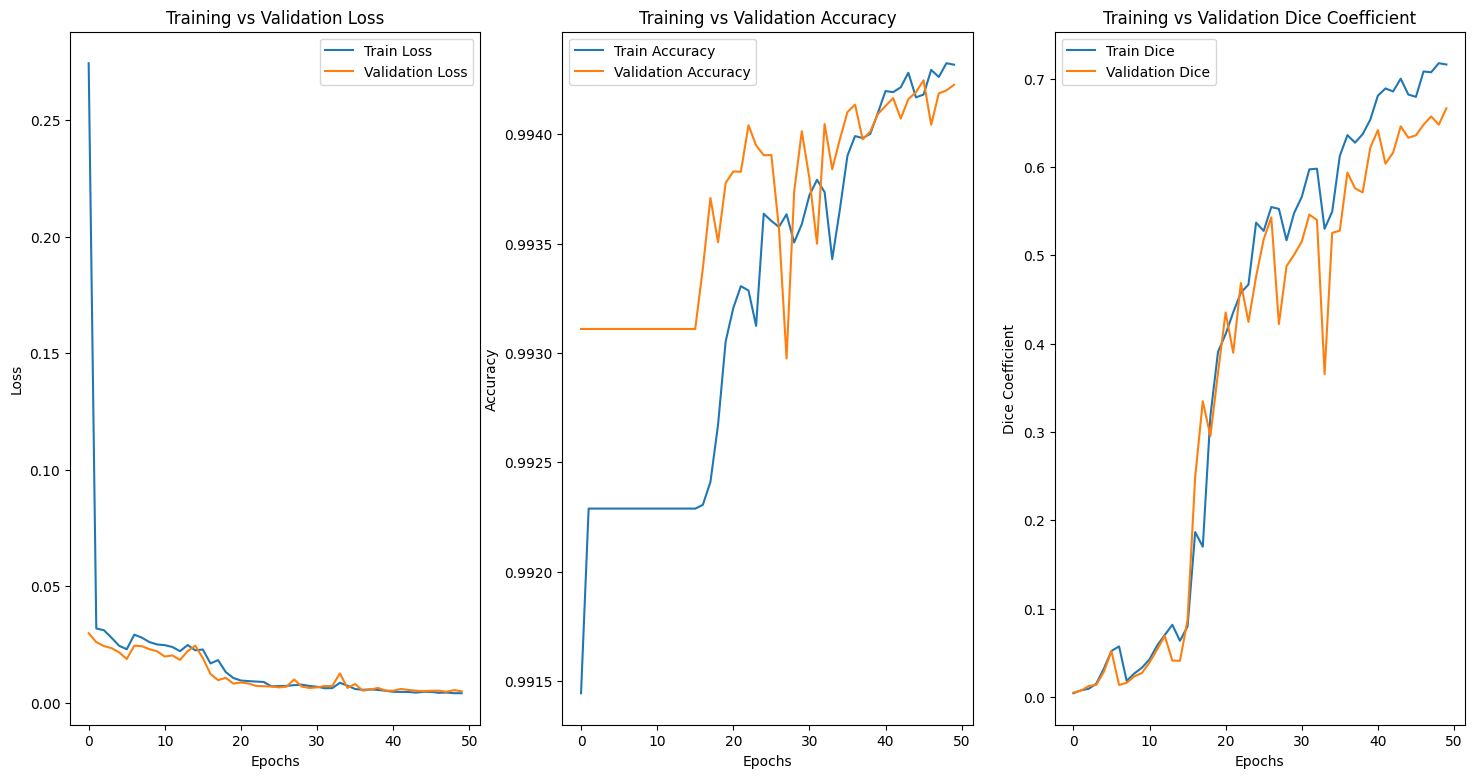

In [29]:
""" plotting the loss and accuracy during training and validation """
plt.figure(figsize=(18, 9))
plt.subplot(1, 3, 1)
plt.plot(unet_history.history['loss'])
plt.plot(unet_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend(['Train Loss', 'Validation Loss'])
plt.subplot(1, 3, 2)
plt.plot(unet_history.history['accuracy'])
plt.plot(unet_history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.subplot(1, 3, 3)
plt.plot(unet_history.history['dice_coefficient'])
plt.plot(unet_history.history['val_dice_coefficient'])
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Training vs Validation Dice Coefficient')
plt.legend(['Train Dice', 'Validation Dice'])

In [30]:
""" Carregando o modelo salvo """
modelo = keras.models.load_model('modelos/unet_model_EGG_CARACU.keras', custom_objects={'dice_coefficient': dice_coefficient})
modelo.evaluate(val_data, verbose= 1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9936 - dice_coefficient: 0.7018 - loss: 0.0051


[0.005116704851388931, 0.993560791015625, 0.7017714381217957]

In [32]:
""" Função: calcular área (predição vs máscara) na dimensão original (403x333) """
def comparar_area_predicao(
    idx,
    model,
    x_imgs,
    y_masks,
    nomes_dados = None,
    orig_size=(403, 333),
    threshold=0.5,
    px_per_cm=24.05,
    smooth=1e-6,
    plot=False,
    overlay_alpha=0.35,
    contours=True,
    verbose=True,
 ):
    """
    Compara a área da predição com a máscara verdadeira na dimensão original.

    Observação: se x_imgs/y_masks estiverem em 256x256 (por causa do pre-processamento),
    a comparação em 403x333 é feita via resize NEAREST para manter máscara binária.

    Retorna um dicionário com áreas (px² e cm²), diferença e métricas (Dice/IoU).
    """
    orig_h, orig_w = orig_size  # (H, W)
    cm2_per_px2 = 1.0 / (px_per_cm ** 2)
    # Pega amostra
    x = x_imgs[idx]
    y_true = y_masks[idx]
    # Predição (probabilidade)
    x_in = tf.expand_dims(x, axis=0)
    y_pred = model.predict(x_in, verbose=0)
    y_pred = np.squeeze(y_pred)
    # Binariza
    y_pred_bin = (y_pred >= threshold).astype(np.uint8)
    y_true = np.squeeze(y_true)
    # Se a máscara veio como 0..255, normaliza implicitamente via threshold
    y_true_bin = (y_true >= threshold).astype(np.uint8)
    # Garante 2D
    if y_pred_bin.ndim == 3:
        y_pred_bin = np.squeeze(y_pred_bin)
    if y_true_bin.ndim == 3:
        y_true_bin = np.squeeze(y_true_bin)
    # Resize para dimensão original (OpenCV usa (W,H))
    pred_orig = cv2.resize(y_pred_bin, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST_EXACT)
    true_orig = cv2.resize(y_true_bin, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST_EXACT)
    # Áreas (px²) e (cm²)
    
    # Diametro vertical (de cima para baixo) na dimensão original
    def _diametro_vertical(mask: np.ndarray) -> int:
        ys = np.where(mask > 0)[0]
        if ys.size == 0:
            return 0
        return int(ys.max() - ys.min() + 1)
    diam_pred_px = _diametro_vertical(pred_orig)
    diam_true_px = _diametro_vertical(true_orig)
    diam_pred_cm = diam_pred_px / px_per_cm
    diam_true_cm = diam_true_px / px_per_cm
    diam_diff_px = np.abs(diam_pred_px - diam_true_px)
    diam_diff_cm = np.abs(diam_diff_px / px_per_cm)
    # Métricas na dimensão original
    intersection = int((pred_orig & true_orig).sum())
    union = int((pred_orig | true_orig).sum())

    iou = (intersection + smooth) / (union + smooth)
    result = {
        'idx': idx,
        'orig_size': (orig_h, orig_w),
        'threshold': float(threshold),
        'px_per_cm': float(px_per_cm),
        'diam_pred_px': int(diam_pred_px),
        'diam_true_px': int(diam_true_px),
        'diam_pred_cm': float(diam_pred_cm),
        'diam_true_cm': float(diam_true_cm),
        'diam_diff_px': int(diam_diff_px),
        'diam_diff_cm': float(diam_diff_cm),
        'iou_orig': float(iou),
    }
    if verbose:
        print(
            f"diam_true={diam_true_cm:.3f} cm | diam_pred={diam_pred_cm:.3f} cm | "
            f"diam_diff={diam_diff_cm:+.3f} cm | "
        )
    if plot:
        img = np.squeeze(x)
        # Mostra na dimensão do modelo (p/ referência) e overlays na dimensão original
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        if nomes_dados is not None and len(nomes_dados) > idx:
            plt.title(f'Imagem (modelo) idx={idx} | {nomes_dados[idx][2:6]}')
        else:
            plt.title(f'Imagem (modelo) idx={idx}')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(true_orig, cmap='gray')
        plt.title(f'Máscara verdadeira (orig {orig_h}x{orig_w})')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(pred_orig, cmap='gray')
        plt.title(f'Máscara predita (orig {orig_h}x{orig_w})')
        plt.axis('off')
        plt.show()
        # Overlay (opcional)
        plt.figure(figsize=(7, 7))
        plt.imshow(cv2.resize(img, (orig_w, orig_h), interpolation=cv2.INTER_LINEAR), cmap='gray') # Plano de fundo
        plt.imshow(true_orig, cmap='Reds', alpha=overlay_alpha, vmin=0, vmax=1)
        plt.imshow(pred_orig, cmap='Blues', alpha=overlay_alpha, vmin=0, vmax=1)
        if contours:
            try:
                plt.contour(true_orig, levels=[0.5], colors='red', linewidths=1)
                plt.contour(pred_orig, levels=[0.5], colors='deepskyblue', linewidths=1)
            except Exception:
                pass
        plt.title(f'Overlay (orig) idx={idx} | true=vermelho | pred=azul')
        plt.axis('off')
        plt.show()
    return result

diam_true=0.998 cm | diam_pred=1.289 cm | diam_diff=+0.291 cm | 


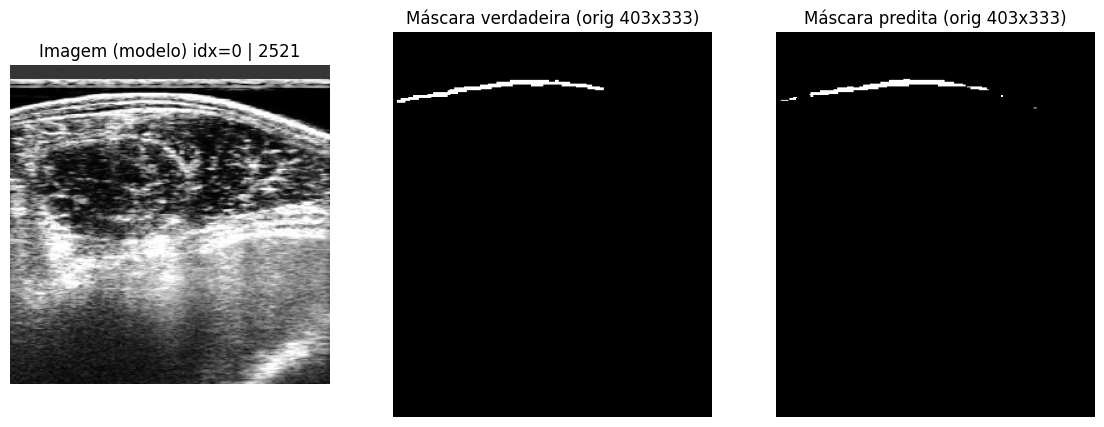

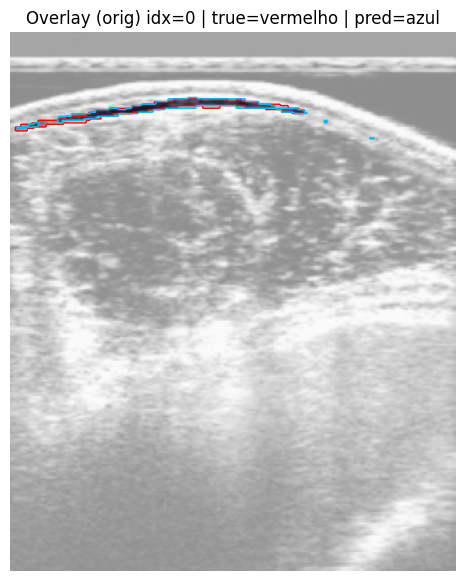

diam_true=0.915 cm | diam_pred=0.790 cm | diam_diff=+0.125 cm | 


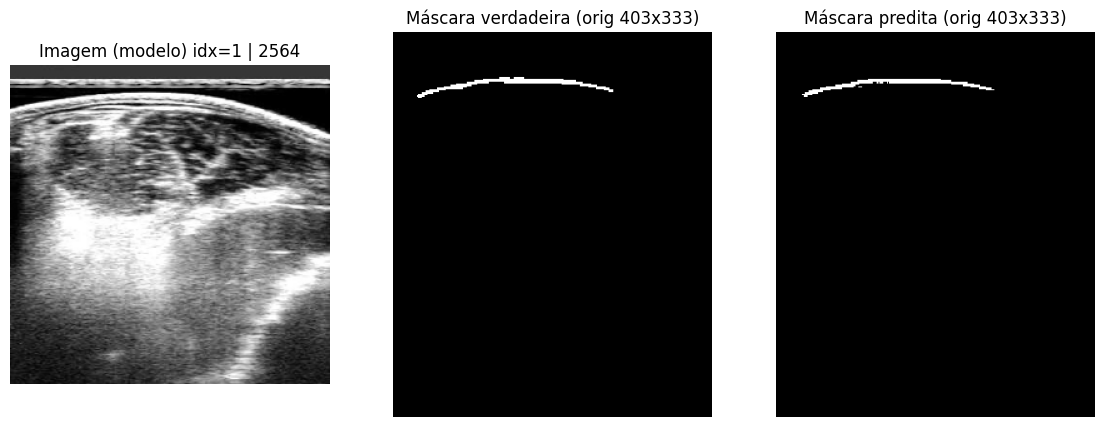

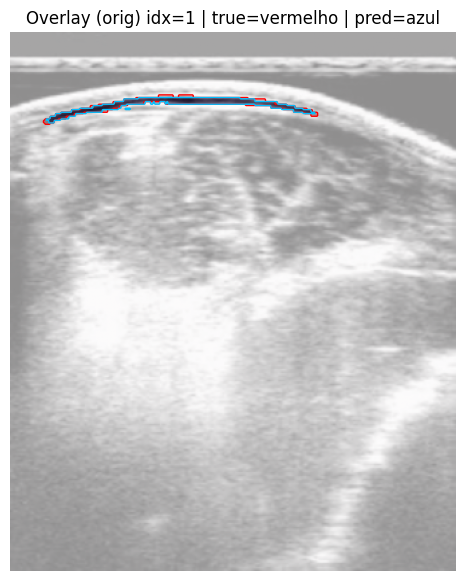

diam_true=0.582 cm | diam_pred=0.665 cm | diam_diff=+0.083 cm | 


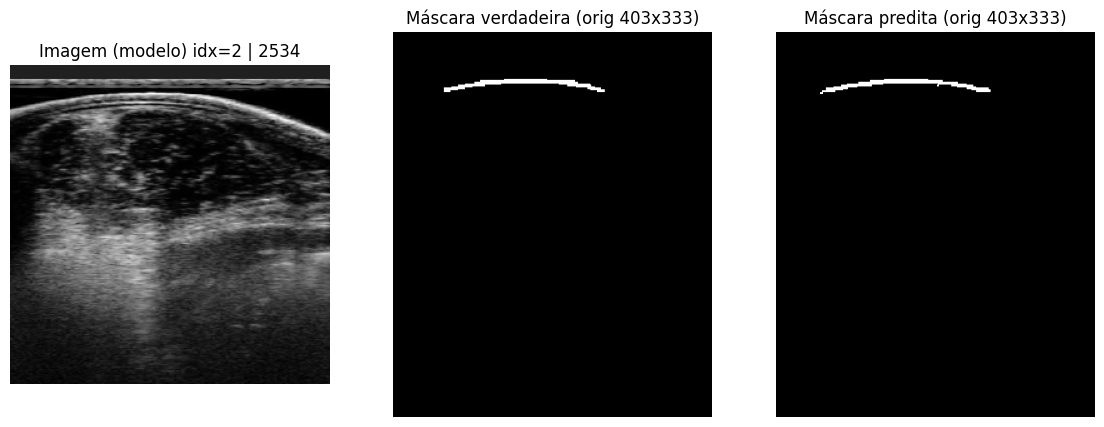

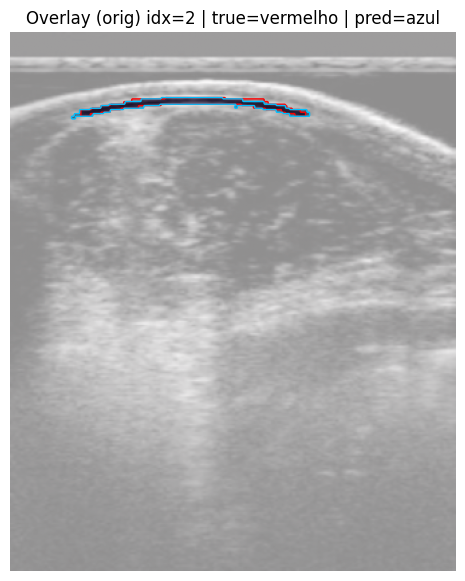

diam_true=0.624 cm | diam_pred=0.624 cm | diam_diff=+0.000 cm | 


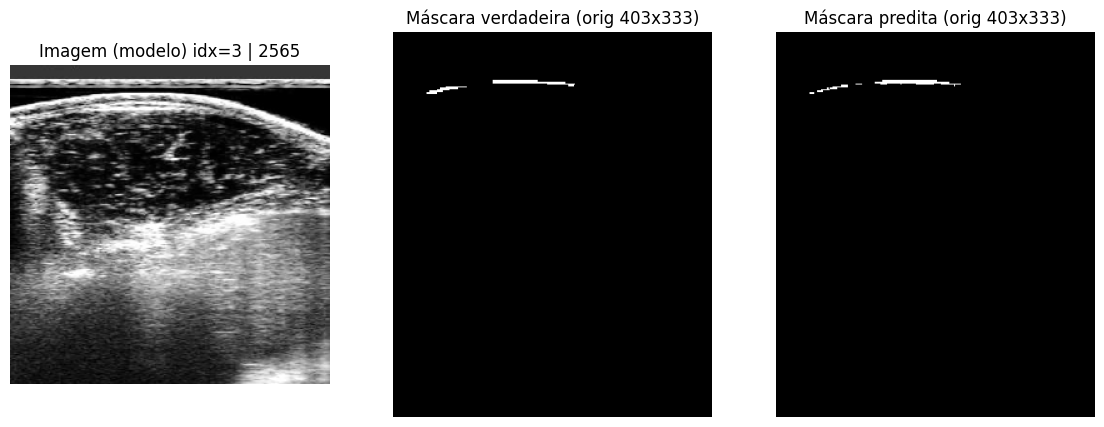

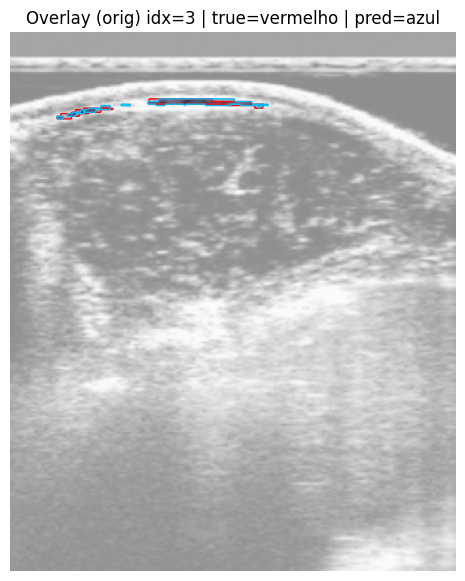

diam_true=0.873 cm | diam_pred=0.457 cm | diam_diff=+0.416 cm | 


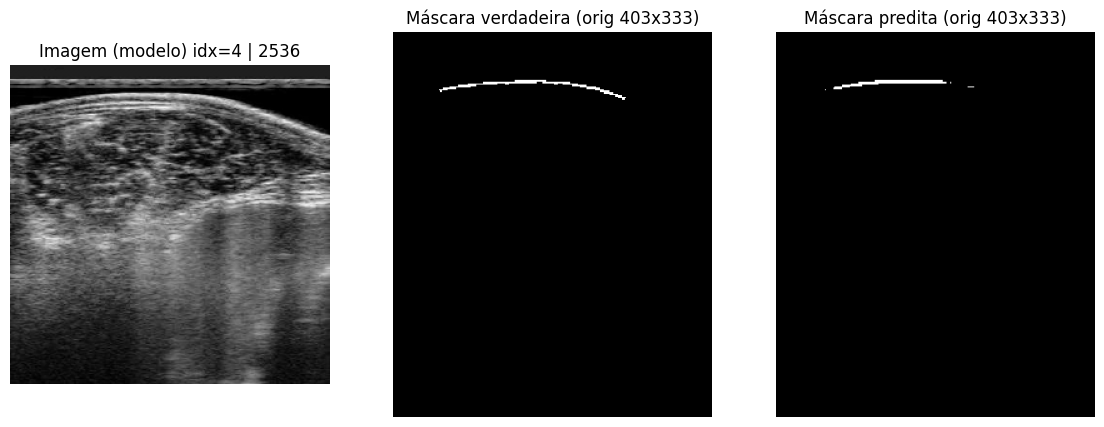

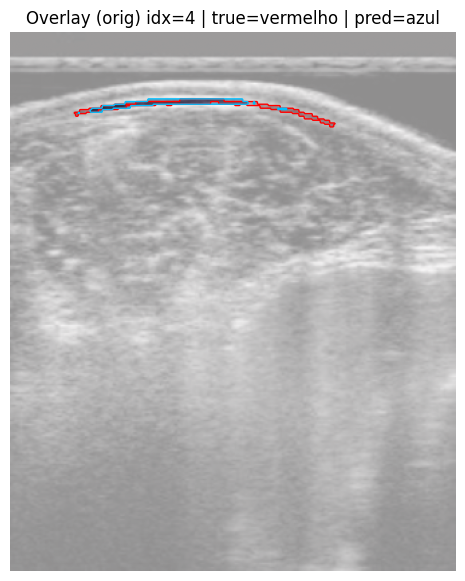

diam_true=0.665 cm | diam_pred=0.624 cm | diam_diff=+0.042 cm | 


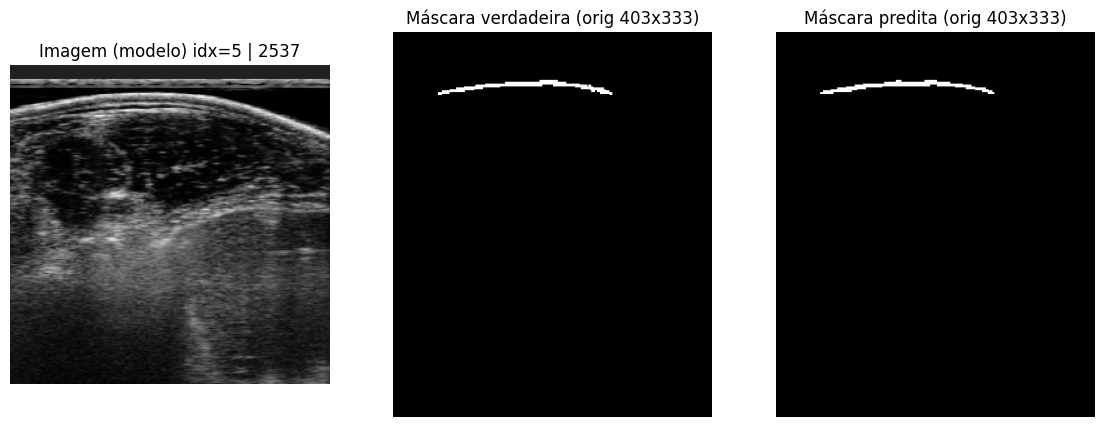

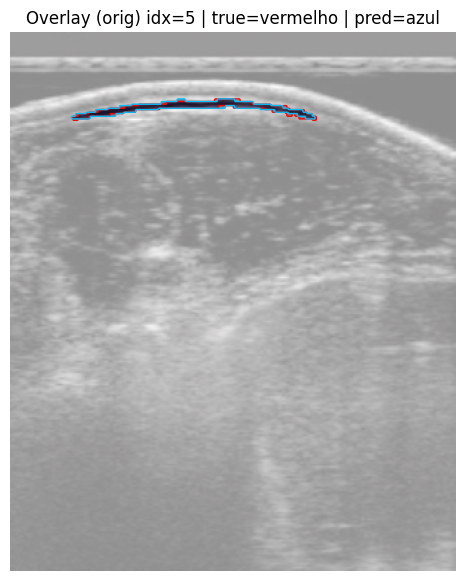

diam_true=0.541 cm | diam_pred=0.541 cm | diam_diff=+0.000 cm | 


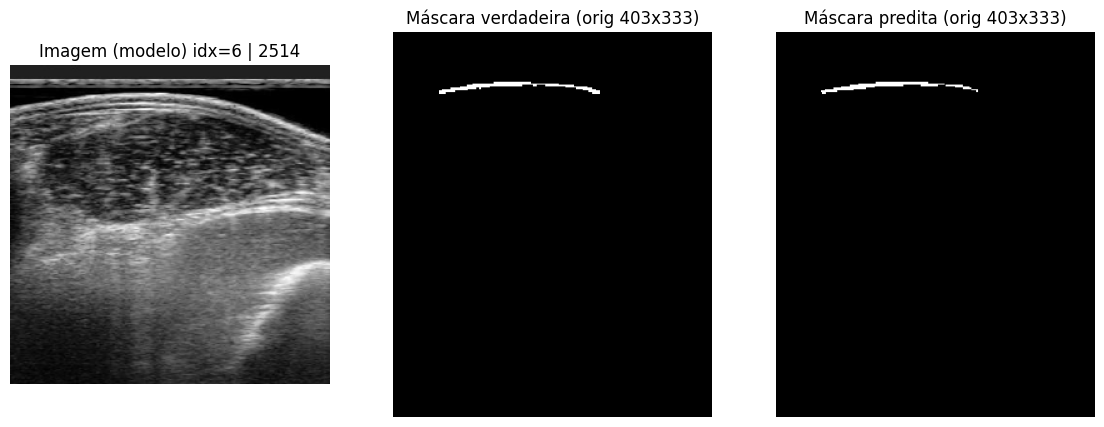

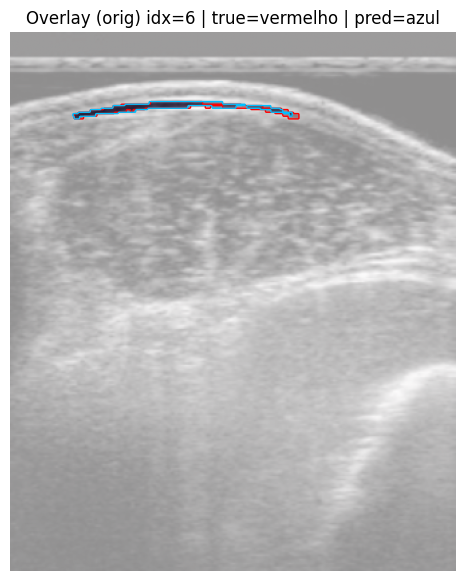

diam_true=0.873 cm | diam_pred=0.624 cm | diam_diff=+0.249 cm | 


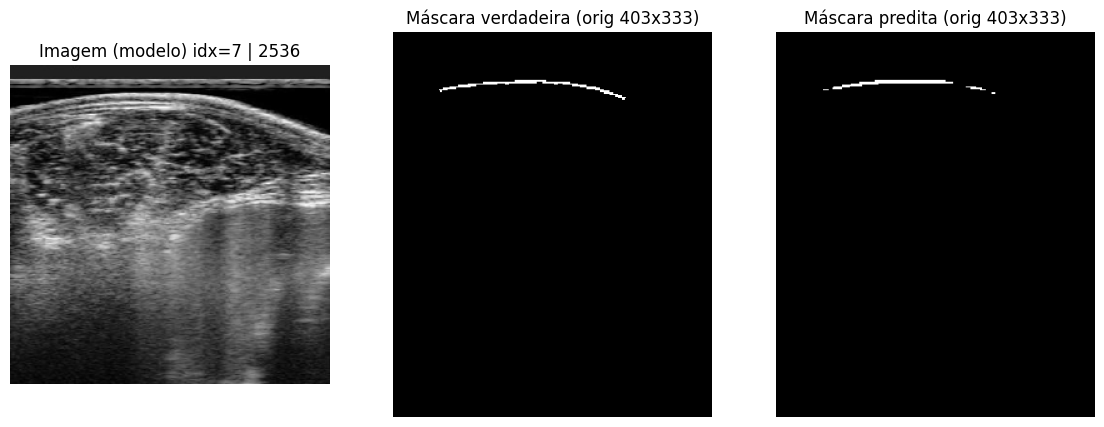

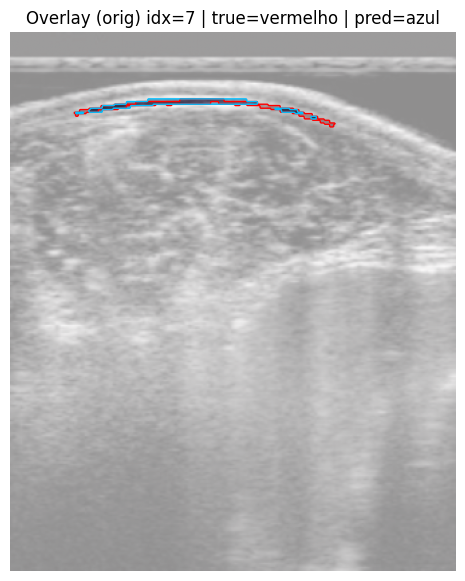

diam_true=0.541 cm | diam_pred=0.665 cm | diam_diff=+0.125 cm | 


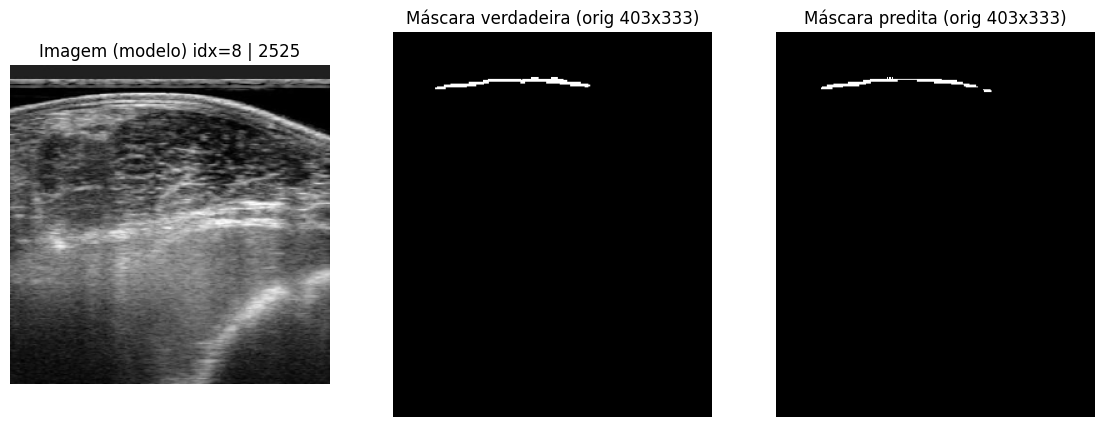

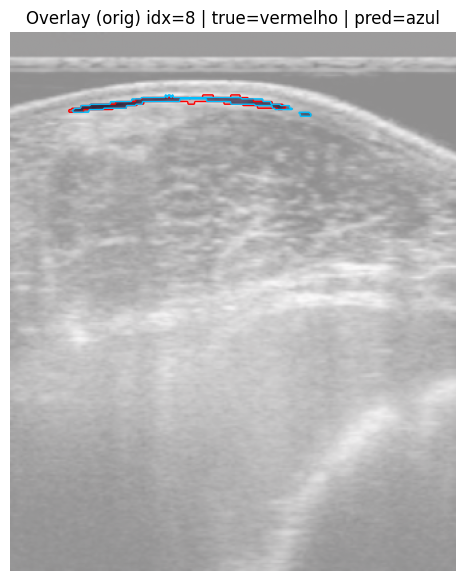

diam_true=0.998 cm | diam_pred=0.956 cm | diam_diff=+0.042 cm | 


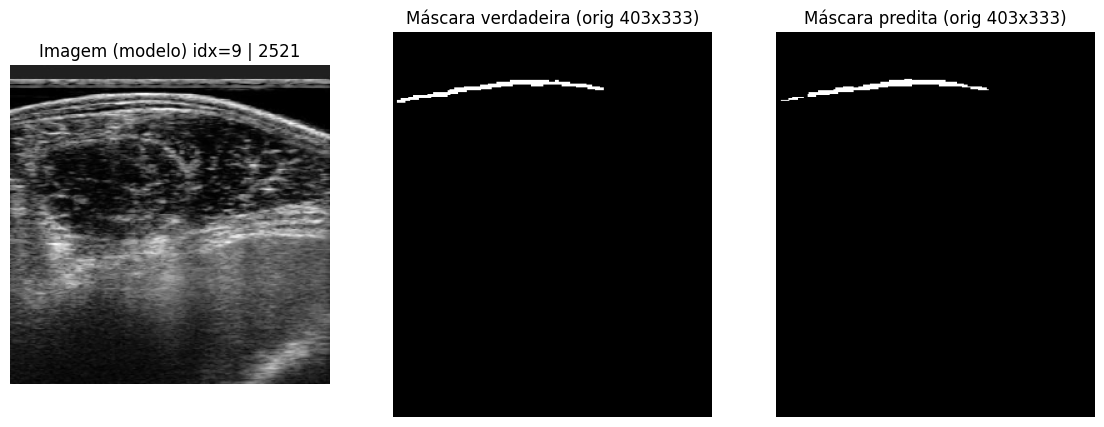

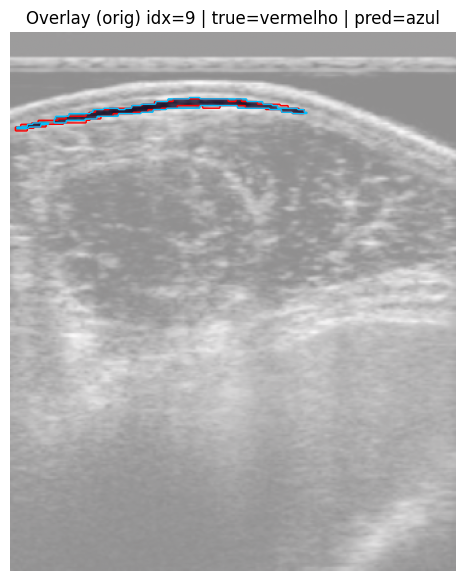

diam_true=0.499 cm | diam_pred=0.416 cm | diam_diff=+0.083 cm | 


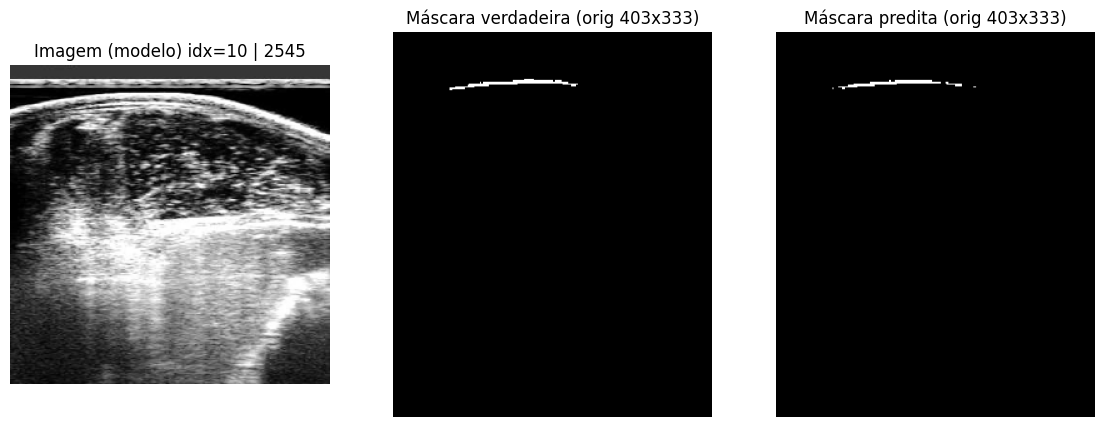

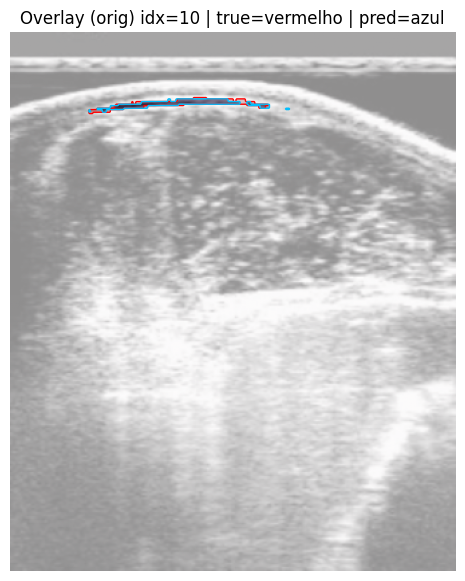

diam_true=1.206 cm | diam_pred=1.164 cm | diam_diff=+0.042 cm | 


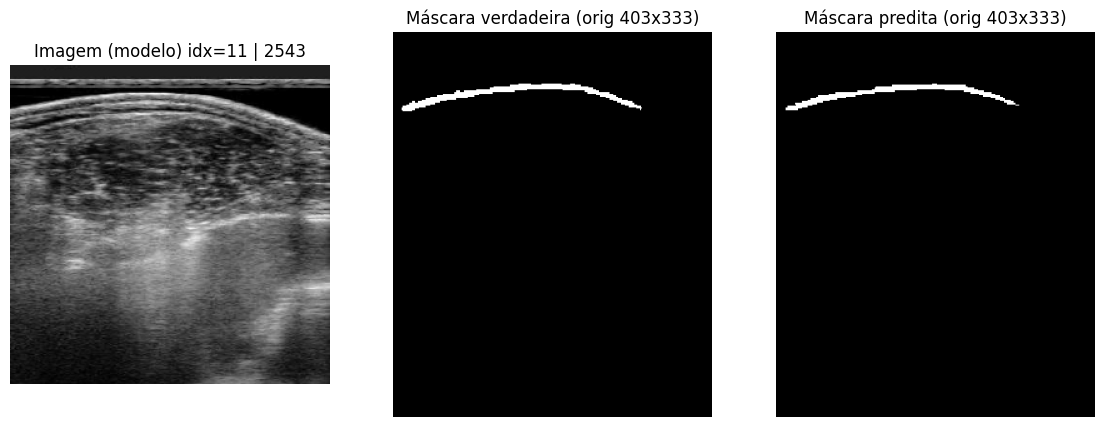

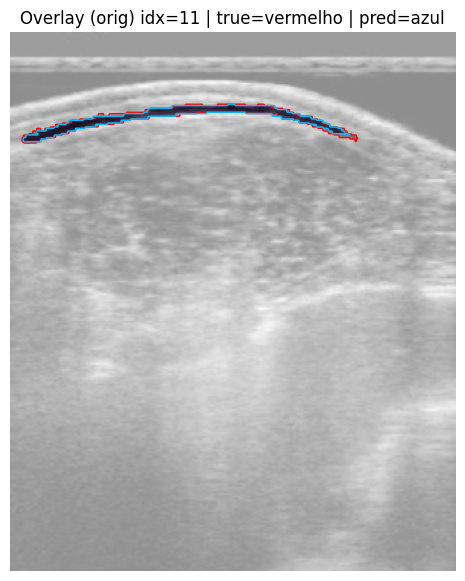

diam_true=0.915 cm | diam_pred=0.873 cm | diam_diff=+0.042 cm | 


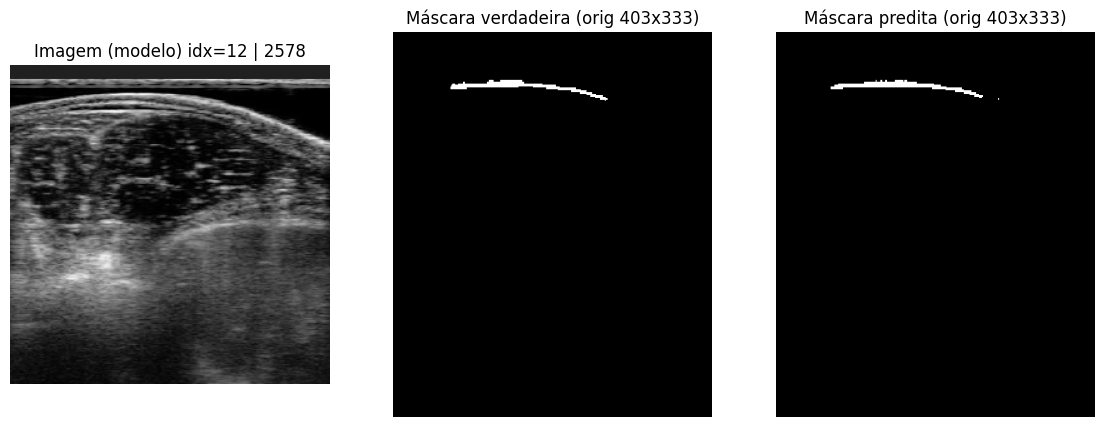

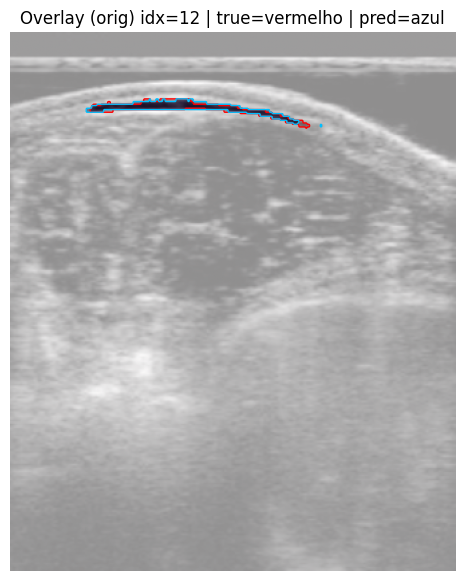

diam_true=0.374 cm | diam_pred=0.748 cm | diam_diff=+0.374 cm | 


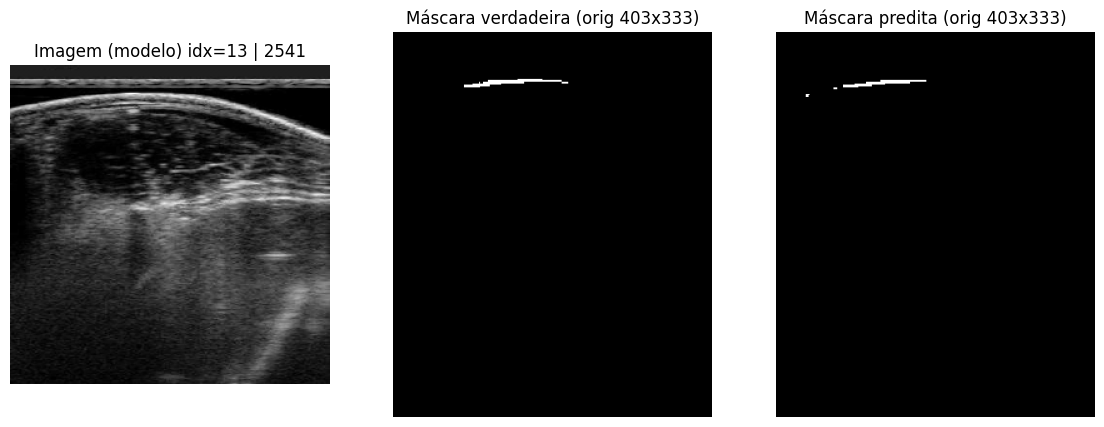

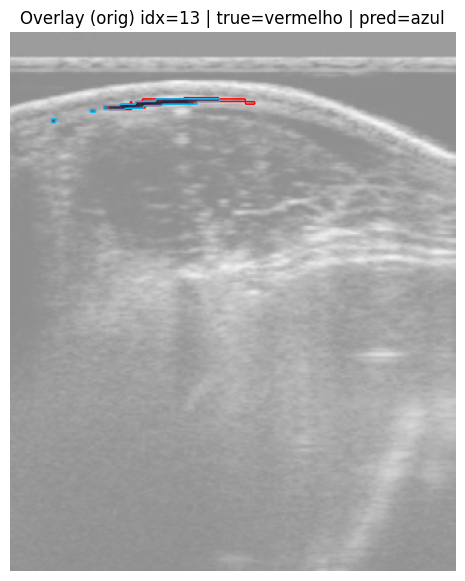

diam_true=0.665 cm | diam_pred=1.040 cm | diam_diff=+0.374 cm | 


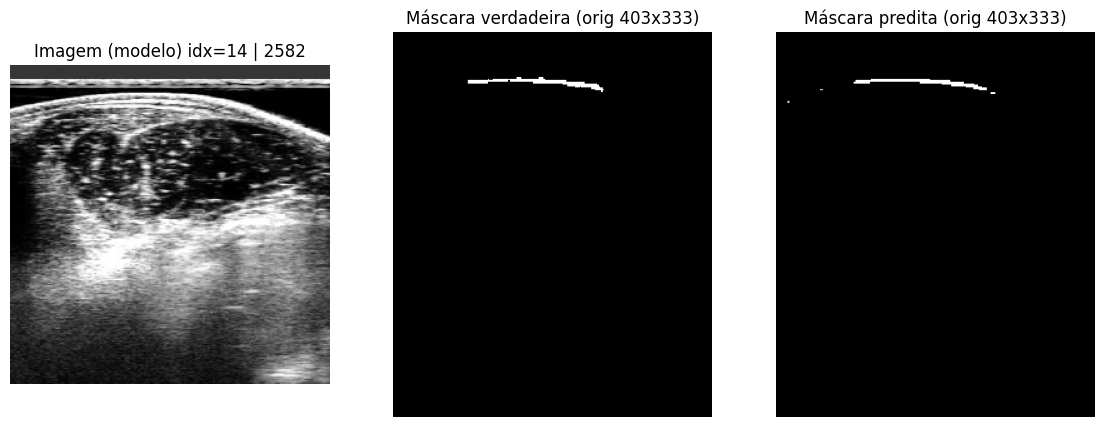

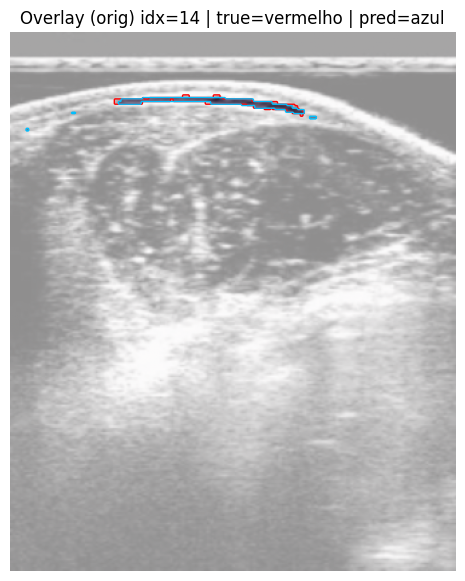

diam_true=0.748 cm | diam_pred=0.665 cm | diam_diff=+0.083 cm | 


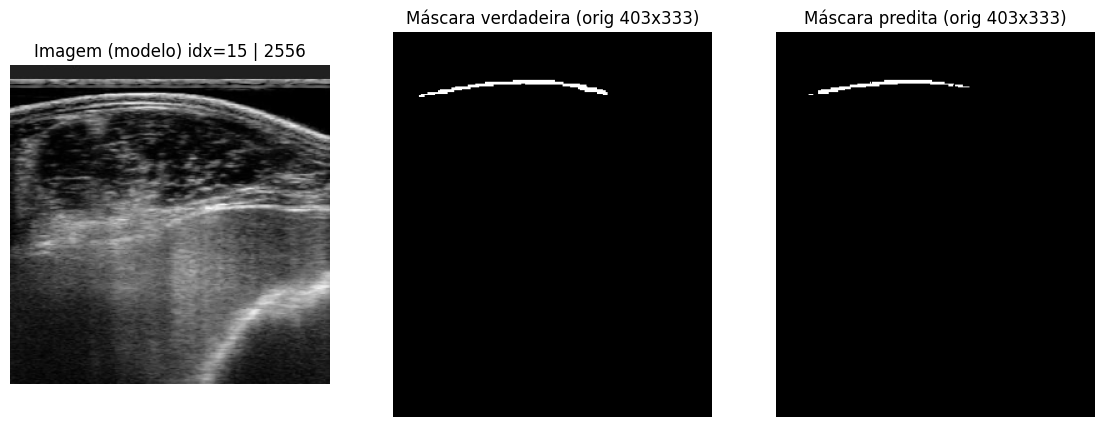

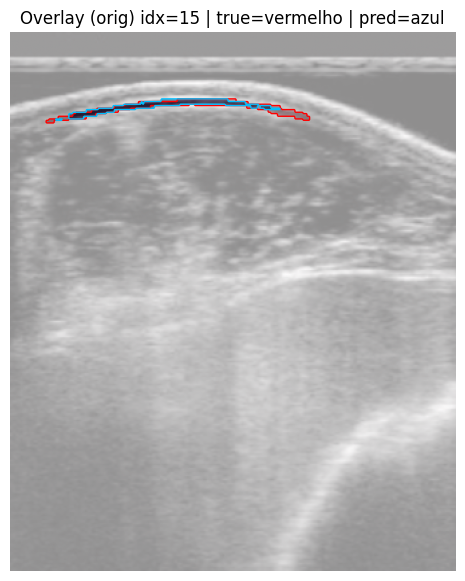

In [34]:
# Print função área
for idx in range(len(x_val)):
    comparar_area_predicao(
        idx,
        modelo,
        x_val,
        y_val,
        nomes_dados= nomes_val,
        orig_size=(403, 333),
        threshold=0.5,
        px_per_cm=24.05,
        smooth=1e-6,
        plot=True,
        overlay_alpha=0.35,
        contours=True,
        verbose=True,
    )

In [35]:
""" Calculando a média dos erros"""
erros = []
area_real: list[float] = [] 
area_predita: list[float] = []
for idx in range(len(x_val)):
    resultado = comparar_area_predicao(
        idx,
        modelo,
        x_val,
        y_val,
        nomes_dados= nomes_val,
        orig_size=(105, 213),
        threshold=0.5,
        px_per_cm=24.05,
        smooth=1e-6,
        plot=False,
        overlay_alpha=0.35,
        contours=True,
        verbose=False,
    )
    erros.append(resultado['diam_diff_cm'])
    area_real.append(resultado['diam_true_cm'])
    area_predita.append(resultado['diam_pred_cm'])

In [36]:
# Print dos erros
print(f'Erro médio na validação: {np.mean(np.abs(erros)):.3f} cm')
print(f'Erro Máximo na validação: {np.max(np.abs(erros)):.3f} cm')
print(f'Erro mínimo na validação: {np.min(np.abs(erros)):.3f} cm')

Erro médio na validação: 0.029 cm
Erro Máximo na validação: 0.125 cm
Erro mínimo na validação: 0.000 cm


In [37]:
# Testando outras imagens 
path_x_new = 'banco2/TreinoGeral/teste2I'
path_y_new = 'banco2/TreinoGeral/teste2'
x_new = banco(path_x_new, resolution=(256,256), grayscale= True)
y_new = banco(path_y_new, resolution=(256,256), grayscale= True)

print(f'Novas imagens : {x_new.shape}')
print(f'Novos rótulos : {y_new.shape}')

new_data = tf.data.Dataset.from_tensor_slices((x_new, y_new))
new_data = new_data.batch(batch_size).prefetch(AUTOTUNE)
modelo.evaluate(new_data, verbose= 1)

Novas imagens : (4, 256, 256, 1)
Novos rótulos : (4, 256, 256, 1)
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.9548 - dice_coefficient: 7.9409e-04 - loss: 0.9490


[0.948989748954773, 0.9547576904296875, 0.0007940896321088076]

diam_true=1.705 cm | diam_pred=1.830 cm | diam_diff=+0.125 cm | 


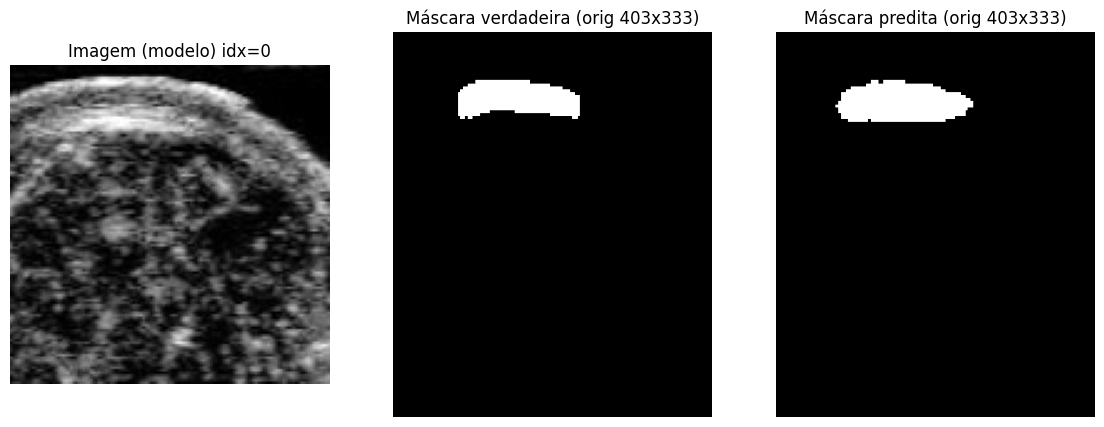

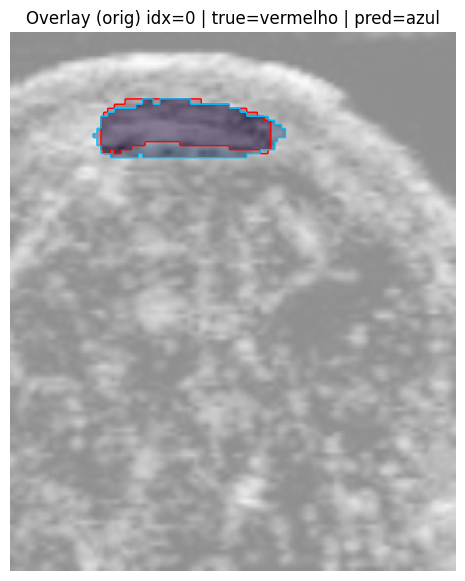

diam_true=2.578 cm | diam_pred=2.245 cm | diam_diff=+0.333 cm | 


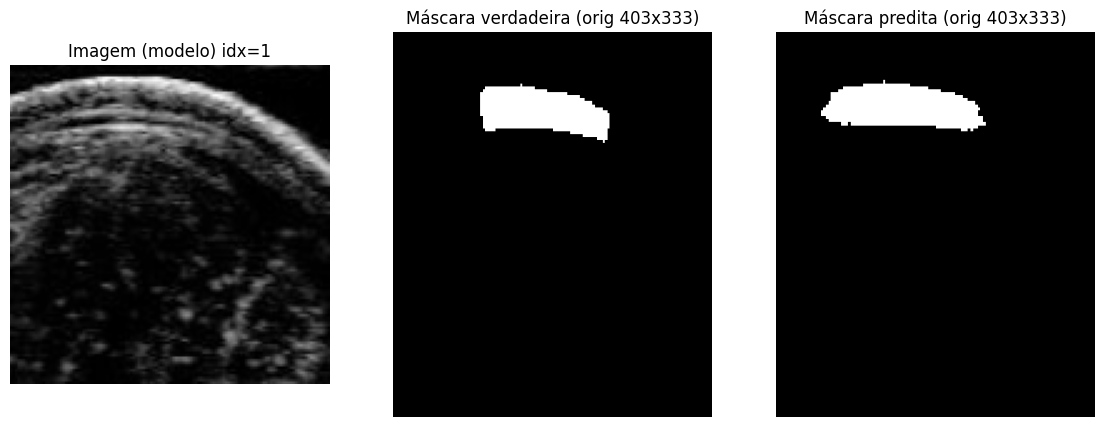

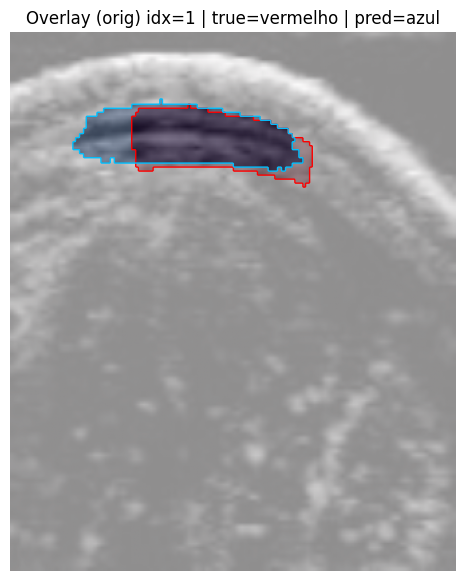

diam_true=2.328 cm | diam_pred=2.079 cm | diam_diff=+0.249 cm | 


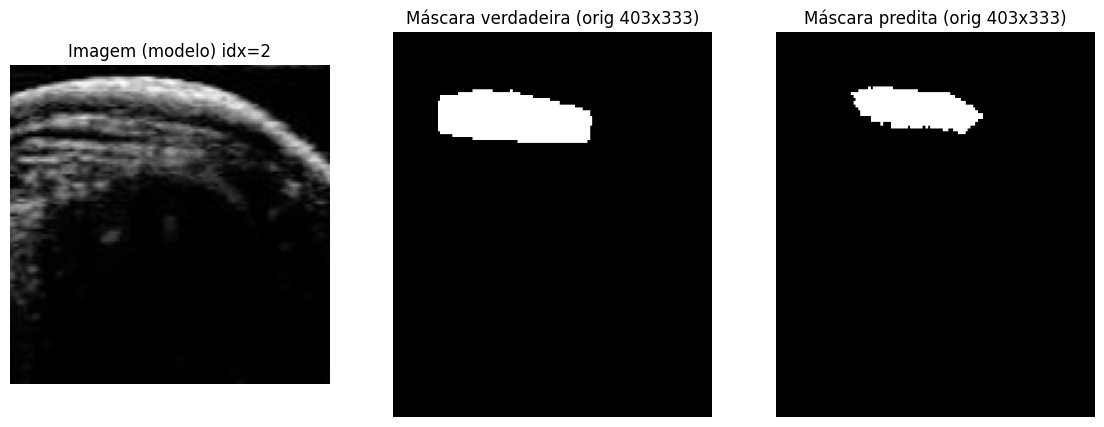

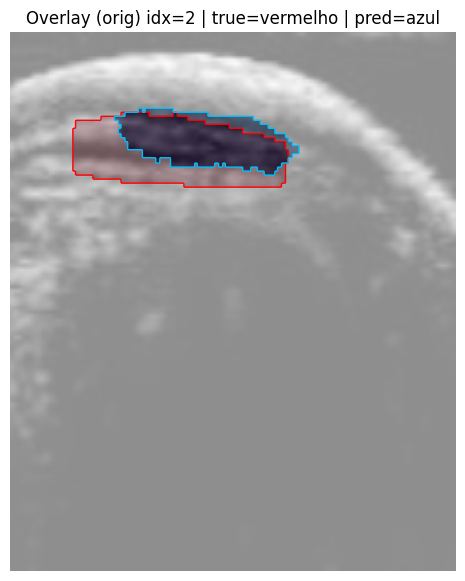

diam_true=1.455 cm | diam_pred=2.370 cm | diam_diff=+0.915 cm | 


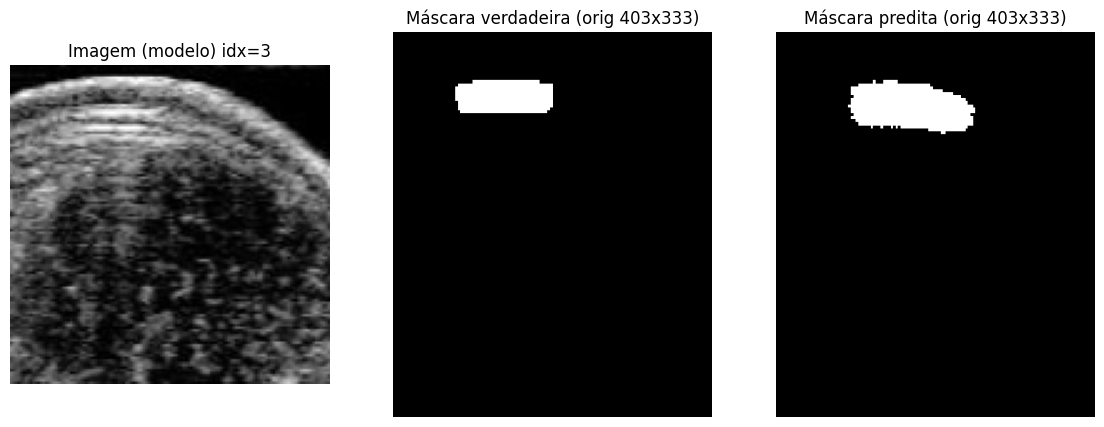

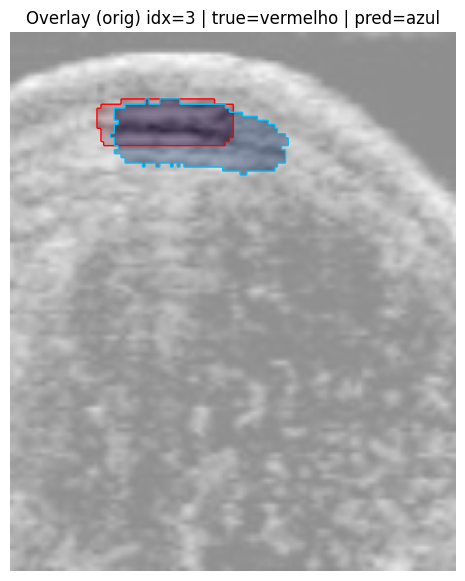

In [90]:
# Print função
for idx in range(len(x_new)):
    comparar_area_predicao(
        idx,
        modelo,
        x_new,
        y_new,
        nomes_dados= None,
        orig_size=(403, 333),
        threshold=0.5,
        px_per_cm=24.05,
        smooth=1e-6,
        plot=True,
        overlay_alpha=0.35,
        contours=True,
        verbose=True,
    )